# 统计metadata的情况

In [4]:
import numpy as np
import pandas as pd
from IPython.display import display

def display_full_table_with_separator(df, splits=2):
    """
    Splits a DataFrame into vertical sections, adds a blank separator column
    between them, and displays them side-by-side with correct integer formatting.
    """
    df_reset = df.reset_index()
    split_size = int(np.ceil(len(df_reset) / splits))
    
    parts = []
    for i in range(splits):
        part = df_reset.iloc[i*split_size : (i+1)*split_size].reset_index(drop=True)
        parts.append(part)
        
    interleaved_parts = []
    for i, part in enumerate(parts):
        interleaved_parts.append(part)
        if i < len(parts) - 1:
            spacer = pd.DataFrame({' | ': [''] * len(part)})
            interleaved_parts.append(spacer)
            
    full_view = pd.concat(interleaved_parts, axis=1)
    
    # --- NEW FIX: Convert numeric columns to nullable integer type ---
    # This loop goes through each column in the final table
    for col in full_view.columns:
        # We only want to convert the data columns, not the text ('BioProject') or spacer (' | ')
        if col in ['female', 'male']:
            # 'Int64' (with a capital I) can handle integers and missing values (NaN)
            full_view[col] = full_view[col].astype('Int64')

    # Display the final, corrected DataFrame
    display(full_view)

# --- You can now call the function as you did before ---
# (Assuming 'study_sex_counts_sorted' is your sorted DataFrame from the previous step)

print("--- Full BioProject Sex Distribution (Sorted & Correctly Formatted) ---")
metadata_final_df = pd.read_csv('Data/sex_prediction_data/all_study/metadata.tsv',sep='\t',index_col=0)
study_sex_counts_df = metadata_final_df.groupby('study')['sex'].value_counts().unstack(fill_value=0)
study_sex_counts_sorted = study_sex_counts_df
display_full_table_with_separator(study_sex_counts_sorted, splits=4)

--- Full BioProject Sex Distribution (Sorted & Correctly Formatted) ---


,study,0,1,|,study,0,1,|,study,0,1,|,study,0,1
0,PRJCA007396,6,53,,PRJEB28350,132,52,,PRJNA375065,30,0,,PRJNA643297,49.0,57.0
1,PRJEB11419,8968,7650,,PRJEB30072,134,127,,PRJNA380944,45,63,,PRJNA644763,143.0,101.0
2,PRJEB11425,61,71,,PRJEB30327,65,77,,PRJNA381333,100,84,,PRJNA668251,14.0,0.0
3,PRJEB13679,525,613,,PRJEB31199,42,42,,PRJNA400445,9,5,,PRJNA682416,12.0,10.0
4,PRJEB13680,117,161,,PRJEB32880,395,249,,PRJNA418115,38,20,,PRJNA683912,185.0,201.0
5,PRJEB13940,570,242,,PRJEB34723,72,67,,PRJNA418765,742,490,,PRJNA695309,65.0,38.0
6,PRJEB14529,335,585,,PRJEB38765,95,139,,PRJNA451534,8,8,,PRJNA706065,0.0,24.0
7,PRJEB14674,144,183,,PRJEB39038,21,20,,PRJNA505336,121,140,,PRJNA722359,31.0,38.0
8,PRJEB15633,41,42,,PRJEB39707,152,242,,PRJNA524816,13,0,,PRJNA727842,53.0,52.0
9,PRJEB18471,37,12,,PRJEB59916,32,8,,PRJNA532645,100,93,,PRJNA731908,43.0,0.0


# 获取模型的评价指标

In [6]:
import torch
import biom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_absolute_error, r2_score, accuracy_score
from membed.Attention_embedding import load_data_imdb, DataLoader, TransformerEncoder, evaluate_auc_gpu, set_seed


membed 0.1.0 initialized.


In [7]:
set_seed(11)
num_steps=600
p_drop=0.4
batch_size=25000
d_model=100
n_layers=1
n_heads=1
group = "sex"

In [9]:

import os
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, matthews_corrcoef
from biom import load_table
 
# 配置路径
base_dir = "Data/sex_prediction_data/"
 
# 初始化参数
results = {
    'disease': [], 'test_study': [], 'auc': [], 'f1': [],
    'mcc': [], 'acc': [], 'confusion_matrix': []
}
 
def evaluate_auc_gpu(Y, prob):
    """综合性能评估函数"""
    Y = Y.numpy().astype('int')
    prob = prob.cpu().detach().numpy()
    
    # 计算ROC曲线
    fpr, tpr, _ = metrics.roc_curve(Y, prob)
    roc_auc = metrics.auc(fpr, tpr)
    
    # 计算PR曲线
    precision, recall, _ = metrics.precision_recall_curve(Y, prob)
    pr_auc = metrics.auc(recall, precision)
    
    # 计算分类指标
    y_pred = (prob > 0.5).astype(int)
    cm = confusion_matrix(Y, y_pred)
    f1 = f1_score(Y, y_pred, average='macro')
    acc = accuracy_score(Y, y_pred)
    mcc = matthews_corrcoef(Y, y_pred)
    
    return roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr
 
def process_biom_table(biom_table, metadata_path):
    """模拟数据预处理函数（需根据实际需求实现）"""
    # 这里应包含特征工程、标准化等处理逻辑
    return {
        'features': np.random.rand(10, 100),  # 示例数据
        'labels': np.random.randint(0, 2, 10)
    }
 
def load_model(model_path):
    """模拟模型加载函数"""
    return torch.load(model_path, map_location=torch.device('cpu'))
 
def save_results(disease, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr):
    """保存分析结果"""
    # 保存指标
    results['disease'].append(disease)
    results['test_study'].append(study)
    results['auc'].append(roc_auc)
    results['f1'].append(f1)
    results['mcc'].append(mcc)
    results['acc'].append(acc)
    results['confusion_matrix'].append(str(cm))  # 将矩阵转为字符串保存
    
    # 保存ROC曲线
    roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
    output_dir = os.path.join(base_dir, disease, study, "results")
    os.makedirs(output_dir, exist_ok=True)
    roc_df.to_csv(os.path.join(output_dir, "roc_curve.csv"), index=False)
 
def process_disease(disease_path):
    """处理单个疾病目录"""
    disease_name = os.path.basename(disease_path)
    print(f"\n{'='*30}\n处理疾病: {disease_name}\n{'='*30}")
    
    # 获取所有研究目录
    study_dirs = [
        d for d in os.listdir(disease_path) 
        if os.path.isdir(os.path.join(disease_path, d))
    ]
    
    # 跳过单个研究的疾病
    if len(study_dirs) <= 1:
        print(f"!! 跳过 {disease_name}，仅有 {len(study_dirs)} 个研究")
        return
    
    if disease_name in ['HTN']:
        print(f"!! 跳过 {disease_name}相关研究")
        return

    # 检查元数据文件
    metadata_path = os.path.join(disease_path, "metadata.tsv")
    if not os.path.exists(metadata_path):
        print(f"!! 严重错误：{disease_name} 缺失元数据文件")
        return
    
    # 遍历每个研究
    for study in study_dirs:
        study_path = os.path.join(disease_path, study)
        print(f"\n-- 处理研究: {study}")
        
        # 验证必需文件
        required_files = {
            'train': 'train_loo.biom',
            'test': 'test_loo.biom',
            'model': os.path.join('results', 'attention_loo.pt')
        }
        
        missing_files = [
            f for f in required_files.values() 
            if not os.path.exists(os.path.join(study_path, f))
        ]
        
        if missing_files:
            print(f"!! 文件缺失: {', '.join(missing_files)}")
            continue
        

        # 加载数据
        train_data = load_data_imdb(f'{study_path}/train_loo.biom',
                                    metadata_path,
                                    group,
                                    'sample',
                                    num_steps)
        test_data = load_data_imdb(f'{study_path}/test_loo.biom',
                                        metadata_path,
                                        group,
                                        'sample',
                                        num_steps)
        
        train_iter = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        test_iter = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False)
        
        table = biom.load_table(f'{study_path}/test_loo.biom')
        study_ordered_sample_ids = table.ids(axis='sample')
        
        # 加载模型
        fid_dict = train_data()
        net = TransformerEncoder(otu_size=len(fid_dict),
                                    seq_len=num_steps+1,
                                    d_model=d_model,
                                    n_layers=n_layers,
                                    n_heads=n_heads,
                                    p_drop=p_drop,
                                    pad_id=fid_dict['<pad>'])
        
        net.load_state_dict( 
                torch.load(
                    f'{study_path}/results/attention_loo.pt',
                    map_location=torch.device('cpu')))
        
        print(net.embedding)  # 确认num_embeddings参数
        
        with torch.no_grad():
            net.eval()
            for i, (features, abundance, group_lables, mask) in enumerate(test_iter):
                pred, _ = net(features, abundance, mask)
                # print(pred)
                # 评估性能
                roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr = evaluate_auc_gpu(group_lables, pred)
                
                pred_probabilities = torch.sigmoid(pred) 
                # print(pred_probabilities)
                if pred_probabilities.ndim > 1 and pred_probabilities.shape[1] == 1:
                    pred_probabilities = pred_probabilities.squeeze(1)
                final_true_labels = group_lables.cpu().numpy().flatten()
                final_pred_probs = pred_probabilities.cpu().numpy().flatten()
                # ---- 保存样本ID、真实标签和预测概率 ----
                output_df_data = {'TrueLabel': final_true_labels, 'PredictedProbability': final_pred_probs}
                can_save_with_ids = False
                if study_ordered_sample_ids is not None:
                    if len(final_true_labels) == len(study_ordered_sample_ids):
                        output_df_data['SampleID'] = study_ordered_sample_ids
                        can_save_with_ids = True
                        print(f"  √ 研究 {study}: 样本ID将包含在概率输出中。")
                    else:
                        print(f"!! 错误: 研究 {study} 的预测/标签数量 ({len(final_true_labels)}) 与获取的样本ID数量 ({len(study_ordered_sample_ids)}) 不匹配!")
                        print("     概率文件将不包含SampleID列。请检查 test_dataset 的ID获取方式。")
                else:
                    print(f"!! 信息: 研究 {study} 未能获取有序样本ID，概率文件将不包含SampleID列。")
                
                predictions_df = pd.DataFrame(output_df_data)
                if can_save_with_ids and 'SampleID' in predictions_df.columns:
                    predictions_df = predictions_df[['SampleID', 'TrueLabel', 'PredictedProbability']]

                output_dir_probs = os.path.join(base_dir, disease_name, study, "results")
                os.makedirs(output_dir_probs, exist_ok=True) 
                probs_output_path = os.path.join(output_dir_probs, "attention_scores.csv")
                predictions_df.to_csv(probs_output_path, index=False)
                print(f"√ 成功保存 {study} 的样本预测概率到 {probs_output_path}")
                
                # 保存结果
                save_results(disease_name, study, roc_auc, pr_auc, f1, mcc, acc, cm, fpr, tpr)
                print(f"√ 成功保存 {study} 结果")
        

for disease_folder in os.listdir(base_dir):
    disease_path = os.path.join(base_dir, disease_folder)
    if os.path.isdir(disease_path):
        process_disease(disease_path)

# 汇总结果
model_res = pd.DataFrame({"disease":results['disease'],"study":results['test_study'],"f1":results['f1'], "auc":results['auc'], "cms":results['confusion_matrix']})
model_res.to_csv("Data/sex_prediction_data/attention_model_loo.csv", index=None)
# print(model_res)
model_res



处理疾病: all_study

-- 处理研究: PRJCA007396


Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJCA007396: 样本ID将包含在概率输出中。
√ 成功保存 PRJCA007396 的样本预测概率到 Data/sex_prediction_data/all_study/PRJCA007396/results/attention_scores.csv
√ 成功保存 PRJCA007396 结果

-- 处理研究: PRJNA579996
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA579996: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA579996 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA579996/results/attention_scores.csv
√ 成功保存 PRJNA579996 结果

-- 处理研究: PRJEB14674
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB14674: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB14674 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB14674/results/attention_scores.csv
√ 成功保存 PRJEB14674 结果

-- 处理研究: PRJNA532645
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA532645: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA532645 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA532645/results/attention_scores.csv
√ 成功保存 PRJNA532645 结果

-- 处理研究: PRJNA644763
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA644763: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA644763 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA644763/results/attention_scores.csv
√ 成功保存 PRJNA644763 结果

-- 处理研究: qiita_2639
Embedding(14119, 100, padding_idx=1)
  √ 研究 qiita_2639: 样本ID将包含在概率输出中。
√ 成功保存 qiita_2639 的样本预测概率到 Data/sex_prediction_data/all_study/qiita_2639/results/attention_scores.csv
√ 成功保存 qiita_2639 结果

-- 处理研究: qiita_11757
Embedding(14119, 100, padding_idx=1)
  √ 研究 qiita_11757: 样本ID将包含在概率输出中。
√ 成功保存 qiita_11757 的样本预测概率到 Data/sex_prediction_data/all_study/qiita_11757/results/attention_scores.csv
√ 成功保存 qiita_11757 结果

-- 处理研究: PRJNA722359
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA722359: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA722359 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA722359/results/attenti

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB28088: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB28088 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB28088/results/attention_scores.csv
√ 成功保存 PRJEB28088 结果

-- 处理研究: PRJNA381333
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA381333: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA381333 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA381333/results/attention_scores.csv
√ 成功保存 PRJNA381333 结果

-- 处理研究: PRJEB30327
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB30327: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB30327 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB30327/results/attention_scores.csv
√ 成功保存 PRJEB30327 结果

-- 处理研究: PRJEB13940
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB13940: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB13940 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB13940/results/attention_scores.csv
√ 成功保存 PRJEB13940 结果

-- 处理研究: PRJNA418765
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA418765: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA418765 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA418765/results/attention_scores

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB59916: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB59916 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB59916/results/attention_scores.csv
√ 成功保存 PRJEB59916 结果

-- 处理研究: PRJEB13679
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB13679: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB13679 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB13679/results/attention_scores.csv
√ 成功保存 PRJEB13679 结果

-- 处理研究: PRJEB23239
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB23239: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB23239 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB23239/results/attention_scores.csv
√ 成功保存 PRJEB23239 结果

-- 处理研究: PRJNA626610
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA626610: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA626610 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA626610/results/attention_scores.csv
√ 成功保存 PRJNA626610 结果

-- 处理研究: PRJNA317429
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA317429: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA317429 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA317429/results/attention_scores.csv
√ 成功保存 PRJNA317429 结果

-- 处理研究: PRJNA313074
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA313074: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA313074 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA313074/results/attention_scores.csv
√ 成功保存 PRJNA313074 结果

-- 处理研究: PRJEB27304
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB27304: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB27304 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB27304/results/attention_scores.csv
√ 成功保存 PRJEB27304 结果

-- 处理研究: PRJNA400445
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA400445: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA400445 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA400445/results/attention_scores.csv
√ 成功保存 PRJNA400445 结果

-- 处理研究: PRJEB32880


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB32880: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB32880 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB32880/results/attention_scores.csv
√ 成功保存 PRJEB32880 结果

-- 处理研究: PRJEB13680
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB13680: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB13680 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB13680/results/attention_scores.csv
√ 成功保存 PRJEB13680 结果

-- 处理研究: qiita_10532
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_10532: 样本ID将包含在概率输出中。
√ 成功保存 qiita_10532 的样本预测概率到 Data/sex_prediction_data/all_study/qiita_10532/results/attention_scores.csv
√ 成功保存 qiita_10532 结果

-- 处理研究: PRJNA682416
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA682416: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA682416 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA682416/results/attention_scores.csv
√ 成功保存 PRJNA682416 结果

-- 处理研究: PRJEB39707


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB39707: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB39707 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB39707/results/attention_scores.csv
√ 成功保存 PRJEB39707 结果

-- 处理研究: PRJNA734860
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA734860: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA734860 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA734860/results/attention_scores.csv
√ 成功保存 PRJNA734860 结果

-- 处理研究: PRJEB39038
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB39038: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB39038 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB39038/results/attention_scores.csv
√ 成功保存 PRJEB39038 结果

-- 处理研究: PRJNA850658
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA850658: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA850658 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA850658/results/attention_scores.csv
√ 成功保存 PRJNA850658 结果

-- 处理研究: PRJEB19996
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB19996: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB19996 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB19996/results/attention_scores.csv
√ 成功保存 PRJEB19996 结果

-- 处理研究: PRJEB19825
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB19825: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB19825 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB19825/results/attention_scores.csv
√ 成功保存 PRJEB19825 结果

-- 处理研究: PRJEB99111
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB99111: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB99111 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB99111/results/attention_scores.csv
√ 成功保存 PRJEB99111 结果

-- 处理研究: PRJNA642975
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA642975: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA642975 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA642975/results/attention_scores.

/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA505336: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA505336 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA505336/results/attention_scores.csv
√ 成功保存 PRJNA505336 结果

-- 处理研究: PRJEB11419
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB11419: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB11419 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB11419/results/attention_scores.csv
√ 成功保存 PRJEB11419 结果

-- 处理研究: PRJNA418115
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA418115: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA418115 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA418115/results/attention_scores.csv
√ 成功保存 PRJNA418115 结果

-- 处理研究: qiita_11884
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_11884: 样本ID将包含在概率输出中。
√ 成功保存 qiita_11884 的样本预测概率到 Data/sex_prediction_data/all_study/qiita_11884/results/attention_scores.csv
√ 成功保存 qiita_11884 结果

-- 处理研究: PRJNA695309
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA695309: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA695309 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA695309/results/attention_scores.csv
√ 成功保存 PRJNA695309 结果

-- 处理研究: PRJEB9365
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB9365: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB9365 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB9365/results/attention_scores.csv
√ 成功保存 PRJEB9365 结果

-- 处理研究: PRJEB30072
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB30072: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB30072 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB30072/results/attention_scores.csv
√ 成功保存 PRJEB30072 结果

-- 处理研究: PRJNA539858
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA539858: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA539858 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA539858/results/attention_scores.csv
√ 成功保存 PRJNA539858 结果

-- 处理研究: PRJEB11425
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB11425: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB11425 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB11425/results/attention_scores.csv
√ 成功保存 PRJEB11425 结果

-- 处理研究: PRJNA380944
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA380944: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA380944 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA380944/results/attention_scores.csv
√ 成功保存 PRJNA380944 结果

-- 处理研究: PRJNA362944
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA362944: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA362944 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA362944/results/attention_scores.csv
√ 成功保存 PRJNA362944 结果

-- 处理研究: PRJNA575620
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA575620: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA575620 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA575620/results/attention_scores.csv
√ 成功保存 PRJNA575620 结果

-- 处理研究: PRJNA356372


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA356372: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA356372 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA356372/results/attention_scores.csv
√ 成功保存 PRJNA356372 结果

-- 处理研究: PRJNA727842
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA727842: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA727842 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA727842/results/attention_scores.csv
√ 成功保存 PRJNA727842 结果

-- 处理研究: PRJEB14529
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB14529: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB14529 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB14529/results/attention_scores.csv
√ 成功保存 PRJEB14529 结果

-- 处理研究: PRJEB22786
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB22786: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB22786 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB22786/results/attention_scores.csv
√ 成功保存 PRJEB22786 结果

-- 处理研究: PRJNA342347
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA342347: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA342347 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA342347/results/attention_scores.csv
√ 成功保存 PRJNA342347 结果

-- 处理研究: qiita_11484
Embedding(14119, 100, padding_idx=1)
  √ 研究 qiita_11484: 样本ID将包含在概率输出中。
√ 成功保存 qiita_11484 的样本预测概率到 Data/sex_prediction_data/all_study/qiita_11484/results/attention_scores.csv
√ 成功保存 qiita_11484 结果

-- 处理研究: PRJEB38765
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB38765: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB38765 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB38765/results/attention_scores.csv
√ 成功保存 PRJEB38765 结果

-- 处理研究: PRJEB15633
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB15633: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB15633 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB15633/results/attention_scores.csv
√ 成功保存 PRJEB15633 结果

-- 处理研究: PRJNA643297
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJNA643297: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA643297 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA643297/results/attention_scores.csv
√ 成功保存 PRJNA643297 结果

-- 处理研究: PRJEB27517
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB27517: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB27517 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB27517/results/attention_scores.csv
√ 成功保存 PRJEB27517 结果

-- 处理研究: PRJEB28350
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB28350: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB28350 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB28350/results/attention_scores.csv
√ 成功保存 PRJEB28350 结果

-- 处理研究: qiita_12382
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 qiita_12382: 样本ID将包含在概率输出中。
√ 成功保存 qiita_12382 的样本预测概率到 Data/sex_prediction_data/all_study/qiita_12382/results/attention_scores.csv
√ 成功保存 qiita_12382 结果

-- 处理研究: PRJNA579491
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA579491: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA579491 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA579491/results/attention_scores.csv
√ 成功保存 PRJNA579491 结果

-- 处理研究: PRJEB18471
Embedding(14119, 100, padding_idx=1)


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


  √ 研究 PRJEB18471: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB18471 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB18471/results/attention_scores.csv
√ 成功保存 PRJEB18471 结果

-- 处理研究: PRJEB27306
Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJEB27306: 样本ID将包含在概率输出中。
√ 成功保存 PRJEB27306 的样本预测概率到 Data/sex_prediction_data/all_study/PRJEB27306/results/attention_scores.csv
√ 成功保存 PRJEB27306 结果

-- 处理研究: PRJNA603512


/home/cjj/miniconda3/envs/microbiome_deep/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Embedding(14119, 100, padding_idx=1)
  √ 研究 PRJNA603512: 样本ID将包含在概率输出中。
√ 成功保存 PRJNA603512 的样本预测概率到 Data/sex_prediction_data/all_study/PRJNA603512/results/attention_scores.csv
√ 成功保存 PRJNA603512 结果


,disease,study,f1,auc,cms
0,all_study,PRJCA007396,0.092308,0.783019,[[ 6 0]\n [53 0]]
1,all_study,PRJNA579996,0.562212,0.743590,[[13 0]\n [ 5 1]]
2,all_study,PRJEB14674,0.419902,0.635284,[[133 11]\n [158 25]]
3,all_study,PRJNA532645,0.341297,0.565591,[[100 0]\n [ 93 0]]
4,all_study,PRJNA644763,0.375059,0.538462,[[140 3]\n [100 1]]
...,...,...,...,...,...
60,all_study,qiita_12382,0.429245,0.714286,[[91 0]\n [30 0]]
61,all_study,PRJNA579491,0.338071,0.548358,[[44 2]\n [48 1]]
62,all_study,PRJEB18471,0.430233,0.711712,[[37 0]\n [12 0]]
63,all_study,PRJEB27306,0.051724,0.480769,[[ 3 0]\n [52 0]]


In [ ]:
import re
import csv
from pathlib import Path
import pandas as pd

def extract_metrics(text_path):
    # 正则匹配模式
    disease_pattern = re.compile(r'^Processing disease:\s+(\w+)')  # 疾病行
    study_pattern = re.compile(r'^(\w+)\s+K_')                     # studyId行
    metric_pattern = re.compile(r'(AUC ROC|Average Precision|F1 value|mcc value|aupr value|acc value):\s+([0-9.]+)')  # 指标行
    
    # 混淆矩阵相关变量
    matrix_lines_remaining = 0
    current_matrix = []
    current_confusion_matrix = None

    records = []
    current_study = None
    current_disease = None

    with open(text_path, 'r') as f:
        for line in f:
            line = line.rstrip()  # 去除行尾换行符

            # 匹配疾病行
            disease_match = disease_pattern.match(line)
            if disease_match:
                current_disease = disease_match.group(1)
                matrix_lines_remaining = 0  # 重置状态
                current_confusion_matrix = None
                continue

            # 匹配study行
            study_match = study_pattern.match(line)
            if study_match:
                current_study = study_match.group(1)
                matrix_lines_remaining = 0  # 重置状态
                current_confusion_matrix = None
                continue

            # 匹配混淆矩阵标题行
            if "conflusion Matrix" in line:  # 容忍拼写错误
                matrix_lines_remaining = 2
                current_matrix = []
                continue

            # 提取混淆矩阵数据
            if matrix_lines_remaining > 0:
                row_match = re.match(r'\s*\[\s*(\d+)\s+(\d+)\s*\]', line)
                if row_match:
                    current_matrix.append([
                        int(row_match.group(1)),
                        int(row_match.group(2))
                    ])
                    matrix_lines_remaining -= 1
                    if matrix_lines_remaining == 0:
                        current_confusion_matrix = current_matrix
                else:
                    matrix_lines_remaining = 0  # 格式不符则放弃

            # 匹配指标行
            if current_study:
                metrics = dict(metric_pattern.findall(line))
                if metrics:
                    record = {
                        "studyId": current_study,
                        "disease": current_disease,
                        **{k: float(v) for k, v in metrics.items()}
                    }
                    # 添加混淆矩阵
                    # print(current_confusion_matrix)s
                    if current_confusion_matrix:
                        record.update({
                            "tn": current_confusion_matrix[0][0],
                            "fp": current_confusion_matrix[0][1],
                            "fn": current_confusion_matrix[1][0],
                            "tp": current_confusion_matrix[1][1],
                            "confusion_matrix": str(current_confusion_matrix)
                        })
                        current_confusion_matrix = None  # 重置
                    records.append(record)

    # 创建DataFrame
    df = pd.DataFrame(records)
    
    # 美化显示格式
    pd.options.display.float_format = '{:.4f}'.format
    display(df)
    return df

# 使用示例
input_file = Path("./log/4_21_RF.out")
RF_model_res = extract_metrics(input_file)
RF_model_res.to_csv("Data/sex_prediction_data/RF_model_loo.csv", index=None)

In [10]:
import pandas as pd
 
# 读取两个CSV文件
df_attention = pd.read_csv("Data/sex_prediction_data/attention_model_loo.csv")
df_rf = pd.read_csv("Data/sex_prediction_data/RF_model_loo.csv")
 
# 统一研究ID列名
df_attention = df_attention.rename(columns={"studyId": "study","disease":'disease_name_ab'})
df_rf = df_rf.rename(columns={"studyId": "study","disease":'disease_name_ab'})
# 按study列进行内连接合并（只保留双方共有的study）
merged_df = pd.merge(
    df_attention, 
    df_rf,
    on=["study","disease_name_ab"],
    how="inner"
)
 
# 保存结果
merged_df.to_csv("Data/sex_prediction_data/all_model_loo.csv", index=False)
merged_df

,disease_name_ab,study,f1,auc,cms,AUC ROC,Average Precision,F1 value,mcc value,aupr value,acc value
0,all_study,PRJCA007396,0.092308,0.783019,[[ 6 0]\n [53 0]],0.5629,0.9263,0.5977,0.2468,0.9270,0.8983
1,all_study,PRJNA579996,0.562212,0.743590,[[13 0]\n [ 5 1]],0.5128,0.4672,0.5043,0.0358,0.4347,0.5263
2,all_study,PRJEB14674,0.419902,0.635284,[[133 11]\n [158 25]],0.5921,0.6494,0.3800,0.0694,0.6483,0.5657
3,all_study,PRJNA532645,0.341297,0.565591,[[100 0]\n [ 93 0]],0.5162,0.5308,0.3337,NaN,0.5228,0.4819
4,all_study,PRJNA644763,0.375059,0.538462,[[140 3]\n [100 1]],0.3647,0.3276,0.2907,NaN,0.3227,0.4098
...,...,...,...,...,...,...,...,...,...,...,...
60,all_study,qiita_12382,0.429245,0.714286,[[91 0]\n [30 0]],0.4963,0.2583,0.2778,0.0333,0.2492,0.2975
61,all_study,PRJNA579491,0.338071,0.548358,[[44 2]\n [48 1]],0.5721,0.5584,0.5292,0.2159,0.5498,0.5895
62,all_study,PRJEB18471,0.430233,0.711712,[[37 0]\n [12 0]],0.6700,0.3368,0.6132,0.3454,0.3090,0.6327
63,all_study,PRJEB27306,0.051724,0.480769,[[ 3 0]\n [52 0]],0.3205,0.9191,0.4811,NaN,0.9138,0.9273


# 绘制随机森林和Attention模型的AUC连线图。

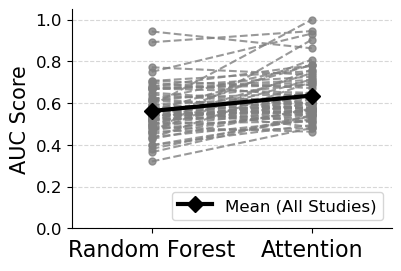

图形已保存为 auc_comparison_gray.png


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define CSV文件路径
csv_path = "Data/sex_prediction_data/all_model_loo.csv"

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"错误: 文件 '{csv_path}' 未找到。请检查文件路径。")
    exit()

required_columns = ['study', 'auc', 'AUC ROC']
missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"错误: CSV文件缺少以下必需列: {', '.join(missing_cols)}")
    exit()

# --- 开始绘图 ---
# Try a slightly wider figure if labels are cramped
fig, ax = plt.subplots(figsize=(4, 3)) # Adjusted figsize for potentially better label spacing
fig.subplots_adjust(right=0.95, left=0.15, bottom=0.15) # Added bottom margin for labels

model_positions = [0, 1]
marker_style = 'o'
marker_size = 5
line_linewidth = 1.5
mean_line_linewidth = 3
mean_marker_size = 8

for _, row_data in df.iterrows():
    ax.plot(
        model_positions,
        [row_data['AUC ROC'], row_data['auc']],
        color='gray',
        alpha=0.8,
        linestyle='--',
        marker=marker_style,
        markersize=marker_size,
        linewidth=line_linewidth
    )

mean_rf_auc = df['AUC ROC'].mean()
mean_attention_auc = df['auc'].mean()
ax.plot(
    model_positions,
    [mean_rf_auc, mean_attention_auc],
    color='black',
    linestyle='-',
    linewidth=mean_line_linewidth,
    marker='D',
    markersize=mean_marker_size,
    label='Mean (All Studies)',
    zorder=10
)

ax.grid(True, linestyle='--', alpha=0.5, axis='y')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(0.0, 1.05)
ax.set_title('', fontsize=16, pad=15, weight='bold')
ax.set_xticks(model_positions)

# --- KEY MODIFICATION AREA FOR FONT SIZE ---
# Adjust this fontsize value as needed.
# If 25 truly seems small, there might be a display scaling issue,
# or the text doesn't fit and is being adjusted.
# Try values like 12, 14, 16, 18, 20, etc.
desired_fontsize = 16 # Example: set to a more standard size first
ax.set_xticklabels(['Random Forest', 'Attention'], fontsize=desired_fontsize)
# You can also add rotation if labels are long and overlap:
# ax.set_xticklabels(['Random Forest', 'Attention'], fontsize=desired_fontsize, rotation=45, ha="right")


ax.set_ylabel('AUC Score', fontsize=15)
ax.tick_params(axis='y', which='major', labelsize=12) # Control y-axis tick label size separately
# Note: ax.tick_params(axis='both', ...) would also affect x-axis if used after set_xticklabels,
# but set_xticklabels is more specific for these labels.

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(loc='lower right', fontsize=12, frameon=True)

output_filename = 'auc_comparison_gray.png'
plt.savefig("Figures/"+output_filename, dpi=300, bbox_inches='tight')
plt.show()

print(f"图形已保存为 {output_filename}")